# Learning bounds and the Test set

##### Keywords: empirical risk minimization, Hoeffding's inequality, hypothesis space,  training error, out-of-sample error, testing set, training set, test error, complexity parameter

## Contents
{:.no_toc}
*  
{: toc}

## TL;DR
If you randomly set aside some amount of data [the test set] and don't use it for fitting a model, that set-aside data still a random sample from the full population and (by LLN) can be used to approximate the model's average performance on new data drawn from the population. [And performance on new data is exactly how we want to measure a model]

However, having a test set costs us data that could be used for fitting the model, and if we evaluate the performance of multiple models on the test set and select the best one, we're likely to grab a model that got lucky and think it performs better than it actually does.

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

In [2]:
def make_simple_plot():
    fig, axes=plt.subplots(figsize=(12,5), nrows=1, ncols=2);
    axes[0].set_ylabel("$y$")
    axes[0].set_xlabel("$x$")
    axes[1].set_xlabel("$x$")
    axes[1].set_yticklabels([])
    axes[0].set_ylim([-2,2])
    axes[1].set_ylim([-2,2])
    plt.tight_layout();
    return axes
def make_plot():
    fig, axes=plt.subplots(figsize=(20,8), nrows=1, ncols=2);
    axes[0].set_ylabel("$p_R$")
    axes[0].set_xlabel("$x$")
    axes[1].set_xlabel("$x$")
    axes[1].set_yticklabels([])
    axes[0].set_ylim([0,1])
    axes[1].set_ylim([0,1])
    axes[0].set_xlim([0,1])
    axes[1].set_xlim([0,1])
    plt.tight_layout();
    return axes

## Recap: Revisiting the model

Let $x$ be the fraction of religious people in a county and $y$ be the probability of voting for Romney as a function of $x$. In other words $y_i$ is data that pollsters have taken which tells us their estimate of people voting for Romney and $x_i$ is the fraction of religious people in county $i$. Because poll samples are finite, there is a margin of error on each data point or county $i$, but the Lord also told us the true values.

We have a population of all 200 counties $x$:

In [22]:
dffull=pd.read_csv("data/religion.csv")
df = pd.read_csv("data/noisysample.csv")

In real life we are only given a sample of points. Lets assume that out of this population of 200 points we are given a sample $\cal{D}$ of 30 data points. Such data is called **in-sample data**. Contrastingly, the entire population of data points is also called **out-of-sample data**.

### Important point: One Model Only
This notebook ONLY addresses the question of measuring how well a particular model performs. We take it as given that we've done the work to select a polynomial model with degree 19 and the dataset told us which particular degree-19 polynomial we want to use.

Even though we'll learn how to evaluate the performance of this model, and concievably many other models, we explicitly set aside the task of reliably deciding whether a degree-19 or degree-3 or knn regression model does best.

This notebook is just about measuring how well a single model does.

## The Goal: Estimate A Model's Performance
Models are wrong. If we hand them a new point, freshly drawn from whatever generates new points, the model's guess will not excatly match the point. We can quantify how far off the model is in various ways, including the ever-popular squared error.

But wait. If we handed the model another freshly-drawn point, we'd get a different value of squared error. There is in fact a _distribution_ of possible squared-error values. We summarize that distribution in the usual way and boil our model's performance down to a single number: the mean of the squared-error distribution we'd see if we fed the model new points. We report the mean squared error, where the mean is over new data points.

[Other summaries are possible, and application-sepecific functions to measure prediciton error/loss are common]

So, how can we estimate the average loss we'd see on across a large number of new data points? We know that just taking the mean of the loss function in the training set underestimates the loss we'd see on new data points.

## Testing and Training Sets
The "aha" moment comes when we realize that we can hold back some of our sample. We can average loss on data that is literally freshly drawn from whatever the generating process is!

The key idea here is that even though the test set was collected along side the rest of the data, as long as it was randomly chosen from the full data set it's a completely random sample from the data generating process. (Or, as random as the original data collection). As a random sample from the data-generating process, the LLN claims the expected loss on the test set should come close to the expected loss across the whole population of new points (for large enough test sets).

### Visually
Remember, our overall goal with the test set is to _measure model performance on new data_.

Let us introduce some new terminology. We take the sample of data $\cal{D}$ that we have been given (our in-sample set) and split it into two parts:

1. The **training set**, which is the part of the data we use to fit a model
2. The **testing set**, a smaller part of the data set which we use to see how good our fit was.

This split is done by choosing points at random into these two sets. Typically we might take 80% of our data and put it in the training set, with the remaining amount going into the test set. This can be carried out in python using the `train_test_split` function from `sklearn.model_selection`.

The split is shown in the diagram below:

![m:caption](images/train-test.png)

We ARE taking a hit on the amount of data we have to train our model. The more data we have, the better we can do for our fits. But, you cannot figure out the generalization ability of a learner by looking at the same data it was trained on: there is nothing to generalize to, and as we know we can fit very complex models to training data which have no hope of generalizing. Thus, to estimate the **out-of-sample error or risk**, we must leave data over to make this estimation.

At this point you are thinking: the test set is just another sample of the population, just like the training set. What guarantee do we have that it approximates the out-of-sample error well? And furthermore, if we pick 6 out of 30 points as a test set, why would you expect the estimate to be any good?

We will kind-of hand wavingly show later that the test set error is a good estimate of the out of sample error, especially for larger and larger test sets. You are right to worry that 6 points is perhaps too few, but thats what we have for now, and we shall work with them.

We are **using the training set then, as our in-sample set, and the test set as a proxy for out-of-sample.**.

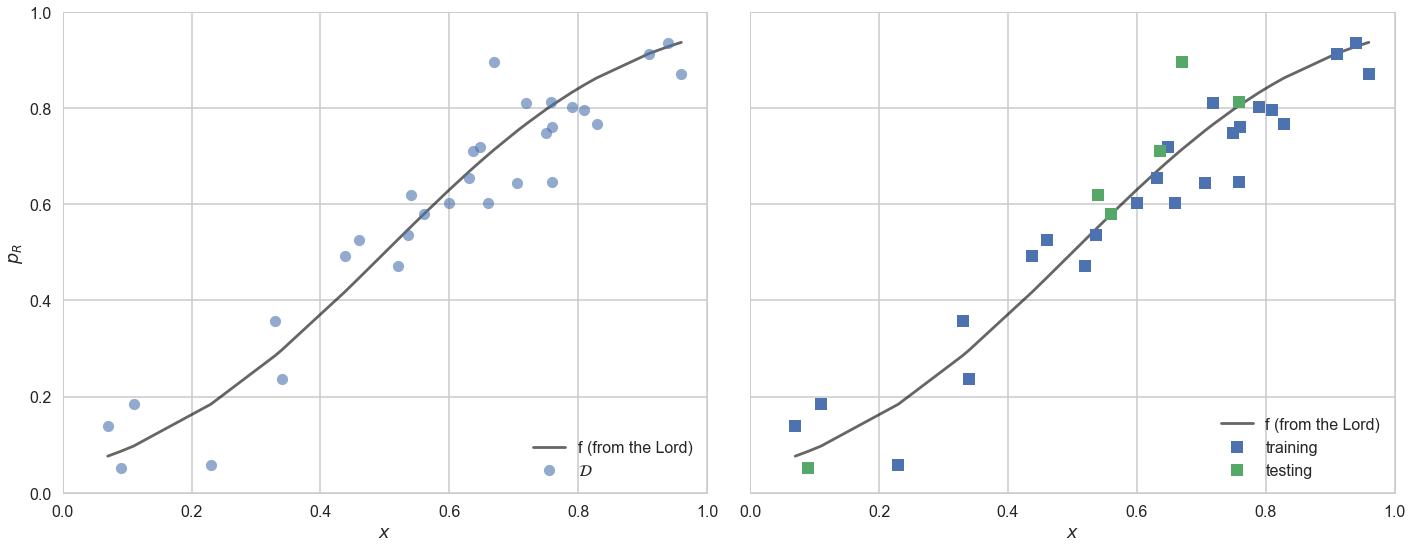

In [6]:
from sklearn.model_selection import train_test_split
datasize=df.shape[0]
#split dataset using the index, as we have x,f, and y that we want to split.
itrain,itest = train_test_split(range(30),train_size=24, test_size=6)
xtrain= df.x[itrain].values
ftrain = df.f[itrain].values
ytrain = df.y[itrain].values
xtest= df.x[itest].values
ftest = df.f[itest].values
ytest = df.y[itest].values

axes=make_plot()
axes[0].plot(df.x,df.f, 'k-', alpha=0.6, label="f (from the Lord)");
axes[0].plot(df.x,df.y, 'o',alpha=0.6, label="$\cal{D}$");
axes[1].plot(df.x,df.f, 'k-', alpha=0.6, label="f (from the Lord)");
axes[1].plot(xtrain, ytrain, 's', label="training")
axes[1].plot(xtest, ytest, 's', label="testing")
axes[0].legend(loc="lower right")
axes[1].legend(loc="lower right");

## Computing Test Set Error

In [21]:
from sklearn.preprocessing import PolynomialFeatures
def make_features(train_set, test_set, degrees):
    traintestlist=[]
    for d in degrees:
        traintestdict={}
        traintestdict['train'] = PolynomialFeatures(d).fit_transform(train_set.reshape(-1,1))
        traintestdict['test'] = PolynomialFeatures(d).fit_transform(test_set.reshape(-1,1))
        traintestlist.append(traintestdict)
    return traintestlist

degrees=range(21)
error_train=np.empty(len(degrees))
error_test=np.empty(len(degrees))

traintestlists=make_features(xtrain, xtest, degrees)

est19 = LinearRegression()
est19.fit(traintestlists[19]['train'], ytrain)
pred_on_train19=est19.predict(traintestlists[19]['train'])
pred_on_test19=est19.predict(traintestlists[19]['test'])
print("Train Set error, Degree 19:   ",mean_squared_error(ytrain, pred_on_train19))
print("Test Set error, Degree 19: ",mean_squared_error(ytest, pred_on_test19))

Train Set error, Degree 19:    0.0012902497821
Test Set error, Degree 19:  9624.60286738


Wow! The test set error can be really different than the training set error. It turns out that the high-degree polynomial may not fit our data well at all, even though it did really well on the training data.

### Warnings
**Model Selection:** It's probably tempting to see how well the a low-degree polynomial does on the test set. This is a great bad idea. _The test set is meant ONLY to estimate how well a specific model will do in future_. If you pick the model that does best on a test set, you risk overftting to that particular test set. However, having a pre-test or validation set of un-used data in which to compare models is a great idea we'll cover soon.

**Error bars:** The out-of-sample loss reported above is based on a sample of 6 test points out of the whole popoulation of possible future points / losses we'd see at those points. There may be a substantial margin of error around the reported estimate of 9624. With a larger training set we could appeal to the LLN and CLT to estiamte true out-of-sample error as our observed test set error, plus or minus some amount. Never take numbers calculated from sample data as gospel truth (or do so, but at your own risk)


### Learning from finite sized samples

If we have very large samples and the distributions are decently well behaved, the law of large numbers tells us that we can estimate expectations nicely by taking sample averages.

However, we are rarely certain that the distribution of future losses is well behaved, or that we have a large enough test set to estimate accurately. But, we can use Hoeffding's inequality and other non-asymptotic results to understand how our sample/test-set quantities differ from the population/true ones.

The simplest version of Hoeffding's inequality applies to the situation where we have a population of binary random variables with fraction $\mu$ of things of one type (e.g. heads/successful prediction). We do not have access to this population, but rather, to a sample drawn with replacement from this population, where the fraction of heads is $\nu$. This version applies directly to classification problems, other versions apply apply to loss functions have an upper/lower bound across the range of future data points (MSE does not technically fit this framework without adjustments).

Hoefding says (where the probability can be thought of as amongst many samples):

$$P(\vert \nu - \mu \vert > \epsilon) \le 2e^{-2\epsilon^2 N}$$

where N is the size of the sample. Clearly the sample fraction approaches the population fraction as N gets very large.

To put this in the context of the learning problem for a hypothesis $h$, identify heads(1) with $h(x_i) \ne f(x_i)$ at sample $x_i$, and tails(0) otherwise. Then $\mu$ is the error rate (also called the 1-0 loss) in the population, which we dont know, while $\nu$ is the same for the sample.

The inequality tells us that the probability that our sample value is more than $\epsilon$ away from the true value decays exponentially with sample size. So the chance of our sample average being wrong by more than .1 falls pretty darn fast (with 0-1 loss: with other bounded losses it's still exponential but N is divided by the squared sum of the bounds, making the gaurantee much slower).

Applied to test-set/full population one can say:

$$P(\vert R_{in}(h) - R_{out}(h) \vert > \epsilon) \le 2e^{-2\epsilon^2 N}$$

Now notice that we fit a $h=g$ on the  training sample. This means that we see as many hypothesis as there are in out hypothesis space. Typically this is infinite, but learning theory allows us to consider a finite effective hypothesis space size, as most hypothesis are not that different from each other. (This is formalized in VC theory, definitely out of scope for this class). 

The problem here is that the Hoeffding inequality holds ONCE we have picked a hypothesis/fitted model $h$, as we need it to label the 1 and 0s. But over the training set we one by one pick all the models in the hypothesis space, before discarding all but one. Thus Hoeffding's inequality does not hold.

However what you can do is this: since the best fit $g$ is one of the $h$ in the hypothesis space $\cal{H}$,  $g$ must be either $h_1$ OR $h_2$ OR....and then are say **effectively** M such choices.

Then:

$$P(\vert R_{in}(g) - R_{out}(g) \vert \ge \epsilon) <= \sum_{h_i \in \cal{H}}  P(\vert R_{in}(h_i) - R_{out}(h_i) \vert \ge \epsilon) <=  2\,M\,e^{-2\epsilon^2 N}$$

In words: the probability the best model is off by epsilon is less than the sum of the probabilites that any particular model is off by epsilon (that sum necescrially includes our the first probability and other positive terms as well. The each term in the sum is subject to Hoefding's, and we get the result.

Thus this tells us that for $N >> M$ our in-sample risk and out-of-sample risk converge asymptotically and that  minimizing our in-sample risk can be used as a proxy for minimizing the unknown out-of-sample risk.

Thus we do not have to hope any more and learning is feasible: if our number of samples outpaces the size/complexity of our hypothesis space we can achieve arbitrarially small average loss on new data.

This also tells us something about complexity. M is a measure of this complexity, and it tells us that our bound is worse for more complex hypothesis spaces. This is our notion of overfitting.

The Hoeffding inequality can be repharased. Pick a  tolerance $\delta$. Then, note that $\vert R_{out} - R_{in} \vert < \epsilon$ with probability $1 - 2\,M\,e^{-2\epsilon^2 N}$. The absolute value implies

$$R_{out} <= R_{in} + \epsilon$$

Now let $\delta =  2\,M\,e^{-2\epsilon^2 N}$.

Then, **with probability** $1-\delta$:

$$R_{out} <= R_{in} + \sqrt{\frac{1}{2N}ln(\frac{2M}{\delta})}$$

### Review

The bound above can now be used to understand why we're emphatic about testing just one fitted model/hypothesis on the test set.

The key observation here is that the test set is looking at only one hypothesis because the fitting is already done on the training set. So $M=1$ in the test set, instead of whatver ungodly number of hypotheses it was in the training set, and the test set error bound is correspondingly lower than the training set error bound!

The M for a given environment is effectively a measure of how optimistically biased that estimate of average loss is. The training set is very optimistically biased about its champion model, since the champion came from among lots of models; the test set is unbiased because there was just one model.

**Final Warning**:  
Remember, a test set has a cost. You have less data in the training set and must thus fit a less complex model. But you get an estimate of how well your model performs.